#### Reference articles/code examples:
- https://learn.microsoft.com/en-gb/azure/cognitive-services/openai/tutorials/embeddings
- https://platform.openai.com/docs/guides/embeddings/use-cases
- https://github.com/openai/openai-cookbook/blob/main/examples/Semantic_text_search_using_embeddings.ipynb


## Semantic text search using Azure OpenAI embeddings

We can search through all our reviews semantically in a very efficient manner and at very low cost, by simply embedding our search query, and then finding the most similar reviews. 

In [1]:
#pip install openai num2words matplotlib plotly scipy scikit-learn transformers

In [2]:
import os
import openai
import pandas as pd
import numpy as np
import re
import requests
import sys
from openai.embeddings_utils import get_embedding, cosine_similarity

In [3]:
# initialize Azure OpenAI
openai.api_type = "azure"
openai.api_base = "https://openairal.openai.azure.com/"
openai.api_version = "2022-12-01"
openai.api_key = open("Azurekey.txt","r").read()

### Load product reviews to create embeddings ### 

In [4]:
#read product reviews
df = pd.read_csv("data/fine_food_reviews_30.csv") 
df["Combined"] = "Summary: " + df["Summary"] + "; Text:" + df["Text"]

In [5]:
df.head()

,Unnamed: 0,ProductId,UserId,Score,Summary,Text,Combined
0,501,B0006345OI,A21YJCM7MR97BS,5,fine for 13 y.o. doggy,My Am Staff is about 13 years old and is a ver...,Summary: fine for 13 y.o. doggy; Text:My Am St...
1,996,B0006349W6,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Summary: Good Training Treat; Text:My dog will...
2,960,B0006349WG,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Summary: Good Training Treat; Text:My dog will...
3,957,B0006349WQ,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Summary: Good Training Treat; Text:My dog will...
4,558,B0006UFY46,AEEVDQNVIH4SJ,5,Great Salmon,This Salmon Is The Best! I Try To Make A Smal...,Summary: Great Salmon; Text:This Salmon Is The...


In [6]:
#Tokens - 100 tokens ~= 75 words

#Show the tokens for line 1
print(df["Text"][0])
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
understand_tokenization = tokenizer.tokenize(df["Text"][0])

from collections import *
import re
print("\nWords: " + str(len(Counter(re.findall(r"[\w']+", df["Text"][0].lower())).keys())))
print("Tokens: " + str(pd.DataFrame(understand_tokenization).count()[0]) + "\n")

understand_tokenization


My Am Staff is about 13 years old and is a very "food-driven" dog. He seems to like this version of Eukanuba just fine, although he is not a picky eater at all! The kibble seems to be a good size for him; some brands of "large dog" food are twice as big, which might be hard for older guys like mine!<br /><br />The price of these 30 lbs bags has gone up from the $40 range to the $50 range, but I know it is better for my dog than the Pedigree that is readily available at Smart & Final, so I stick with this Eukanuba.<br /><br />Plus, you all know the benefits of feeding your dog higher-quality dry food when you go out for a "walk," right? ;-)

Words: 91
Tokens: 172



['My',
 'ĠAm',
 'ĠStaff',
 'Ġis',
 'Ġabout',
 'Ġ13',
 'Ġyears',
 'Ġold',
 'Ġand',
 'Ġis',
 'Ġa',
 'Ġvery',
 'Ġ"',
 'food',
 '-',
 'driven',
 '"',
 'Ġdog',
 '.',
 'ĠHe',
 'Ġseems',
 'Ġto',
 'Ġlike',
 'Ġthis',
 'Ġversion',
 'Ġof',
 'ĠE',
 'uk',
 'an',
 'uba',
 'Ġjust',
 'Ġfine',
 ',',
 'Ġalthough',
 'Ġhe',
 'Ġis',
 'Ġnot',
 'Ġa',
 'Ġpick',
 'y',
 'Ġeater',
 'Ġat',
 'Ġall',
 '!',
 'ĠThe',
 'Ġk',
 'ibble',
 'Ġseems',
 'Ġto',
 'Ġbe',
 'Ġa',
 'Ġgood',
 'Ġsize',
 'Ġfor',
 'Ġhim',
 ';',
 'Ġsome',
 'Ġbrands',
 'Ġof',
 'Ġ"',
 'large',
 'Ġdog',
 '"',
 'Ġfood',
 'Ġare',
 'Ġtwice',
 'Ġas',
 'Ġbig',
 ',',
 'Ġwhich',
 'Ġmight',
 'Ġbe',
 'Ġhard',
 'Ġfor',
 'Ġolder',
 'Ġguys',
 'Ġlike',
 'Ġmine',
 '!',
 '<',
 'br',
 'Ġ/',
 '><',
 'br',
 'Ġ/>',
 'The',
 'Ġprice',
 'Ġof',
 'Ġthese',
 'Ġ30',
 'Ġlbs',
 'Ġbags',
 'Ġhas',
 'Ġgone',
 'Ġup',
 'Ġfrom',
 'Ġthe',
 'Ġ$',
 '40',
 'Ġrange',
 'Ġto',
 'Ġthe',
 'Ġ$',
 '50',
 'Ġrange',
 ',',
 'Ġbut',
 'ĠI',
 'Ġknow',
 'Ġit',
 'Ġis',
 'Ġbetter',
 'Ġfor',
 'Ġmy',
 'Ġdog',

In [7]:
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
understand_tokenization = tokenizer.tokenize("Here is a short section with a long word Floccinaucinihilipilification")
understand_tokenization 


['Here',
 'Ġis',
 'Ġa',
 'Ġshort',
 'Ġsection',
 'Ġwith',
 'Ġa',
 'Ġlong',
 'Ġword',
 'ĠFl',
 'occ',
 'in',
 'auc',
 'in',
 'ihil',
 'ip',
 'il',
 'ification']

### Normalize text ###

In [8]:
# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()
    
    return s

df['Combined'] = df["Combined"].apply(lambda x : normalize_text(x))

### Calculate embedding for review summary and review text and save it to local file ###

In [9]:
df['embedding'] = df["Combined"].apply(lambda x : get_embedding(x, engine = 'textembeddingada002'))
df.to_csv('data/fine_food_reviews_30_with_embeddings.csv')

### Load pre-calculated embedding from file ###

In [10]:
datafile_path = "data/fine_food_reviews_30_with_embeddings.csv"
df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)
df.head(5)
#df["embedding"][0]

,Unnamed: 0.1,Unnamed: 0,ProductId,UserId,Score,Summary,Text,Combined,embedding
0,0,501,B0006345OI,A21YJCM7MR97BS,5,fine for 13 y.o. doggy,My Am Staff is about 13 years old and is a ver...,Summary: fine for 13 y.o. doggy; Text:My Am St...,"[0.017628641799092293, -0.008377001620829105, ..."
1,1,996,B0006349W6,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Summary: Good Training Treat; Text:My dog will...,"[-0.02066964842379093, -0.009581152349710464, ..."
2,2,960,B0006349WG,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Summary: Good Training Treat; Text:My dog will...,"[-0.02066964842379093, -0.009581152349710464, ..."
3,3,957,B0006349WQ,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...,Summary: Good Training Treat; Text:My dog will...,"[-0.02066964842379093, -0.009581152349710464, ..."
4,4,558,B0006UFY46,AEEVDQNVIH4SJ,5,Great Salmon,This Salmon Is The Best! I Try To Make A Smal...,Summary: Great Salmon; Text:This Salmon Is The...,"[0.011180466040968895, -0.03362546116113663, 0..."


### Function to compare the cosine similarity of the query and reviews and show top_n best matches. ###

In [11]:

# search through the reviews for a specific product using natural language text
def search_reviews(df, query, n=3, pprint=True):
    
    query_embedding = get_embedding(query,engine="textembeddingada002")
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, query_embedding)) #not a call to the webservice

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .Combined.str.replace("Summary: ", "")
        .str.replace("; Text:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results


### We can search through these reviews easily.###
To speed up computation, we can use a special algorithm, aimed at faster search through embeddings.

In [12]:
results = search_reviews(df, "find me something that improves sleep", n=1)

breakfast tea: We switch to this decaf tea at night for a great cup of tea and no sleep problems. Thanks for a good cup of tea.



In [13]:
#"Schlaf verbessern" german translation of "improves sleep"
results = search_reviews(df, "Schlaf verbessern", n=1)

breakfast tea: We switch to this decaf tea at night for a great cup of tea and no sleep problems. Thanks for a good cup of tea.



In [14]:
header = "Generate Product name and a few product tagline for the given description:"
strPrompt = header + " ".join(results)

print(strPrompt)
print("\n\r")

response = openai.Completion.create(
    engine="textdavinci003",
    prompt=strPrompt,
    temperature=1, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=400,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)

Generate Product name and a few product tagline for the given description:breakfast tea: We switch to this decaf tea at night for a great cup of tea and no sleep problems. Thanks for a good cup of tea.


Product name: Decaf Dreamtime Tea

Product Taglines: 
1. Sweet Dreams, Naturally. 
2. Caffeinate Your Morning, Decaffeinate Your Night. 
3. Get a Perfect Cup Even After Sunset.


### Visualize embeddings

In [15]:
import pandas as pd
samples = pd.read_json("data/dbpedia_samples.jsonl", lines=True)
categories = sorted(samples["category"].unique())
print("Categories of DBpedia samples:", samples["category"].value_counts())
samples.head()

Categories of DBpedia samples: Artist                    21
Film                      19
Plant                     19
OfficeHolder              18
Company                   17
NaturalPlace              16
Athlete                   16
Village                   12
WrittenWork               11
Building                  11
Album                     11
Animal                    11
EducationalInstitution    10
MeanOfTransportation       8
Name: category, dtype: int64


,text,category
0,Morada Limited is a textile company based in ...,Company
1,The Armenian Mirror-Spectator is a newspaper ...,WrittenWork
2,Mt. Kinka (金華山 Kinka-zan) also known as Kinka...,NaturalPlace
3,Planning the Play of a Bridge Hand is a book ...,WrittenWork
4,Wang Yuanping (born 8 December 1976) is a ret...,Athlete


In [16]:
from openai.embeddings_utils import get_embeddings
openai.api_type = "azure"
openai.api_base = "https://openairal.openai.azure.com/"
openai.api_version = "2022-12-01"
openai.api_key = open("Azurekey.txt","r").read()

url = openai.api_base + "/openai/deployments?api-version=2022-12-01"

# NOTE: The following code will send a query of batch size 200 to /embeddings
#matrix = get_embeddings(samples["text"].to_list(), engine="textembeddingada002")
#matrix = get_embeddings(samples["text"].to_list(), engine="textembeddingada002")
matrix = samples["text"].apply(lambda x : get_embedding(x, engine = 'textembeddingada002'))


In [17]:
matrix = matrix.to_list()

In [18]:
#! pip install ipympl

In [19]:
samples["text"]

0       Morada Limited is a textile company based in ...
1       The Armenian Mirror-Spectator is a newspaper ...
2       Mt. Kinka (金華山 Kinka-zan) also known as Kinka...
3       Planning the Play of a Bridge Hand is a book ...
4       Wang Yuanping (born 8 December 1976) is a ret...
                             ...                        
195     Stanhopea martiana is a species of orchid end...
196     Yawarmayu (Quechua yawar blood mayu river blo...
197     The Charles Granke House at 406 S. Seventh St...
198     Passiflora monadelpha is a species of plant i...
199     Mangifera persiciformis or Peach Mango is a s...
Name: text, Length: 200, dtype: object

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)
samples["embed_vis"] = vis_dims.tolist()

In [21]:
#! pip install matplotlib --upgrade

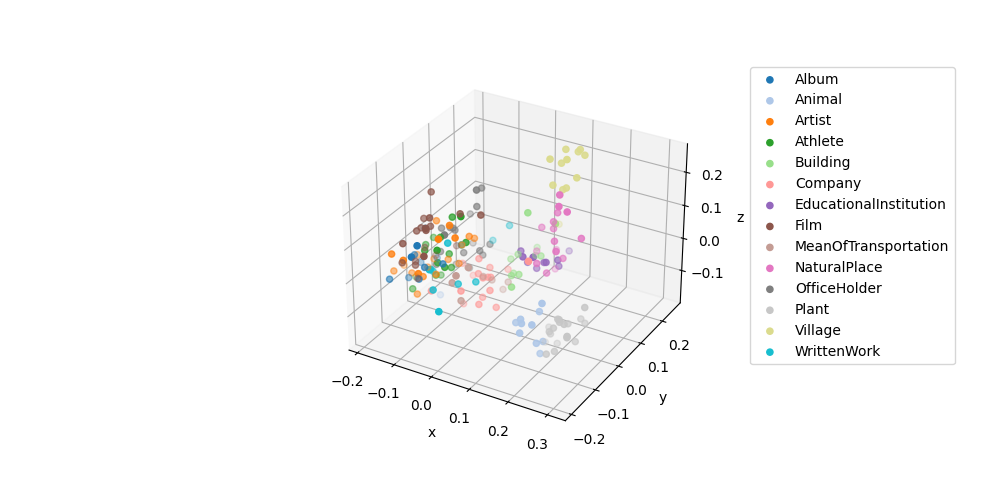

In [22]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

# Plot each sample category individually such that we can set label name.
for i, cat in enumerate(categories):
    sub_matrix = np.array(samples[samples["category"] == cat]["embed_vis"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))

## END ##

In [23]:
results = search_reviews(df, "delicious food", n=3)

Came as expected: It was tasty and fresh. The other one I bought was old and tasted moldy. But this one was good.

Very sweet: I like the crunchy-ness of the middle, but it doesn't have a great flavor, basically just a very sweet taste without much substance. The chocolate around it is pretty sweet too. If you lik

Great Salmon: This Salmon Is The Best! I Try To Make A Small Variety Of Salmon Dishes, But For Me, Salmon Patties As Nice As My Mother Used To Make Is My Favorite!



As we can see, this can immediately deliver a lot of value. In this example we show being able to quickly find the examples of pet food.

In [24]:
results = search_reviews(df, "pet food" , n=2)

My furbabies LOVE these!: Shake the container and they come running. Even my boy cat, who isn't big on ANY food, loves these! A winner in our house! Two paws up!

my dogs love the peanut butter!: First off, read the ingredients, no crazy words I can't pronounce, which means it's all natural! I got the peanut butter treats for my two children: husky/shepherd and



In [25]:
#tiernahrung
results = search_reviews(df, "tiernahrung" , n=2)

My furbabies LOVE these!: Shake the container and they come running. Even my boy cat, who isn't big on ANY food, loves these! A winner in our house! Two paws up!

fine for 13 y.o. doggy: My Am Staff is about 13 years old and is a very "food-driven" dog. He seems to like this version of Eukanuba just fine, although he is not a picky eater at all! The kibble seem



### QnA on top of the content returned ###

In [26]:
#construct a prompt from the returned results

results_string = ""

for value in results:
    results_string += str(value) + "\n "

results_string = results_string[:-1]

print(results_string)

My furbabies LOVE these!: Shake the container and they come running. Even my boy cat, who isn't big on ANY food, loves these! A winner in our house! Two paws up!
 fine for 13 y.o. doggy: My Am Staff is about 13 years old and is a very "food-driven" dog. He seems to like this version of Eukanuba just fine, although he is not a picky eater at all! The kibble seems to be a good size for him; some brands of "large dog" food are twice as big, which might be hard for older guys like mine!<br /><br />The price of these 30 lbs bags has gone up from the $40 range to the $50 range, but I know it is better for my dog than the Pedigree that is readily available at Smart & Final, so I stick with this Eukanuba.<br /><br />Plus, you all know the benefits of feeding your dog higher-quality dry food when you go out for a "walk," right? ;-)



In [27]:
header = """Answer the question as truthfully as possible using the provided context, and if the answer is not contained within the text below, say "I don't know."\n\nContext:\n"""
strPrompt = header + "".join(results_string) + "\n\n Q: " + "what did I get for my two dogs/children?" + "\n A:"

strPrompt = header + "".join(results_string) + "\n\n Q: " + "which food my dog loves" + "\n A:"
#strPrompt = header + "".join(results_string) + "\n\n Q: " + "which food my dog hates" + "\n A:"

strPrompt

'Answer the question as truthfully as possible using the provided context, and if the answer is not contained within the text below, say "I don\'t know."\n\nContext:\nMy furbabies LOVE these!: Shake the container and they come running. Even my boy cat, who isn\'t big on ANY food, loves these! A winner in our house! Two paws up!\n fine for 13 y.o. doggy: My Am Staff is about 13 years old and is a very "food-driven" dog. He seems to like this version of Eukanuba just fine, although he is not a picky eater at all! The kibble seems to be a good size for him; some brands of "large dog" food are twice as big, which might be hard for older guys like mine!<br /><br />The price of these 30 lbs bags has gone up from the $40 range to the $50 range, but I know it is better for my dog than the Pedigree that is readily available at Smart & Final, so I stick with this Eukanuba.<br /><br />Plus, you all know the benefits of feeding your dog higher-quality dry food when you go out for a "walk," right? 

In [28]:
response = openai.Completion.create(
    engine="textdavinci003",
    prompt=strPrompt,
    temperature=1, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=400,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)

Eukanuba
